In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly


In [89]:
import zipfile,fnmatch,os

rootPath = r"./"
pattern = '*.zip'
for root, dirs, files in os.walk(rootPath):
    for filename in fnmatch.filter(files, pattern):
        print(os.path.join(root, filename))
        zipfile.ZipFile(os.path.join(root, filename)).extractall(os.path.join(root, os.path.splitext(filename)[0]))


./061921_A02078.zip


In [90]:
dir = os.path.splitext(filename)[0]

os.listdir(dir)

['ACC.csv',
 'BVP.csv',
 'EDA.csv',
 'HR.csv',
 'IBI.csv',
 'info.txt',
 'tags.csv',
 'TEMP.csv']

In [91]:
ibi = pd.read_csv('./' + dir + '/IBI.csv')
mean_ibi = ibi[' IBI'].mean()

average_heart_rate = 60/mean_ibi


print('mean ibi is :', mean_ibi)
print('mean heart rate :', average_heart_rate.round())


mean ibi is : 0.6810049733644082
mean heart rate : 88.0


In [92]:
ibi.columns

Index(['1624102549.000000', ' IBI'], dtype='object')

In [93]:
import plotly.express as px

df = px.data.stocks()
fig = px.scatter(ibi, y=' IBI')
fig.show()

In [94]:
rr = ibi[' IBI']

# RMSSD: take the square root of the mean square of the differences
rmssd = np.sqrt(np.mean(np.square(np.diff(rr))))
# Mean RR
mean_rr = np.mean(rr)
# SDNN
sdnn = np.std(rr)
# Mean HR
mean_hr = 60 * 1000/np.mean(rr)
# NNxx: sum absolute differences that are larger than 50ms
nnxx = np.sum(np.abs(np.diff(rr)) > 50)*1
# pNNx: fraction of nnxx of all rr-intervals
pnnx = 100 * nnxx / len(rr)

In [95]:
import peakutils
import math, sys

def bvpPeaks(signal):
    cb = np.array(signal)
    x = peakutils.indexes(cb, thres=0.02/max(cb), min_dist=0.1)
    y = []
    i = 0
    while (i < (len(x)-1)):
        if x[i+1] - x[i] < 15:
            y.append(x[i])
            x = np.delete(x, i+1)
        else:
            y.append(x[i])
        i += 1
    return y

def getRRI(signal, start, sample_rate):
    peakIDX = bvpPeaks(signal)
    spr = 1 / sample_rate # seconds between readings
    start_time = float(start)
    timestamp = [start_time, (peakIDX[0] * spr) + start_time ] 
    ibi = [0, 0]
    for i in range(1, len(peakIDX)):
        timestamp.append(peakIDX[i] * spr + start_time)
        ibi.append((peakIDX[i] - peakIDX[i-1]) * spr)

    df = pd.DataFrame({'Timestamp': timestamp, 'IBI': ibi})
    return df

def getHRV(data, avg_heart_rate):
    rri = np.array(data['IBI']) * 1000
    RR_list = rri.tolist()
    #RR_diff = []
    RR_sqdiff = []
    RR_diff_timestamp = []
    cnt = 2
    while (cnt < (len(RR_list)-1)): 
        #RR_diff.append(abs(RR_list[cnt+1] - RR_list[cnt])) 
        RR_sqdiff.append(math.pow(RR_list[cnt+1] - RR_list[cnt], 2)) 
        RR_diff_timestamp.append(data['Timestamp'][cnt])
        cnt += 1
    hrv_window_length = 10
    window_length_samples = int(hrv_window_length*(avg_heart_rate/60))
    #SDNN = []
    RMSSD = []
    index = 1
    for val in RR_sqdiff:
        if index < int(window_length_samples):
            #SDNNchunk = RR_diff[:index:]
            RMSSDchunk = RR_sqdiff[:index:]
        else:
            #SDNNchunk = RR_diff[(index-window_length_samples):index:]
            RMSSDchunk = RR_sqdiff[(index-window_length_samples):index:]
        #SDNN.append(np.std(SDNNchunk))
        RMSSD.append(math.sqrt(np.std(RMSSDchunk)))
        index += 1
    dt = np.dtype('Float64')
    #SDNN = np.array(SDNN, dtype=dt)
    RMSSD = np.array(RMSSD, dtype=dt)
    df = pd.DataFrame({'Timestamp': RR_diff_timestamp, 'HRV': RMSSD})
    return df



In [96]:
BVP_DF = pd.read_csv('./' + dir + '/BVP.csv')
HR_DF = pd.read_csv('./' + dir + '/HR.csv')

column = list(HR_DF)[0]
temp = HR_DF.drop(0, axis = 0)
HR = temp[column]
HR = HR.tolist()

column2 = list(BVP_DF)[0]
sample_rate = BVP_DF[column2][0]
temp = BVP_DF.drop(0, axis = 0)
temp['spData'] = 0
temp.loc[temp[column2] > 0, 'spData'] = temp[column2]
signal = temp['spData'].tolist()

RRI_DF = getRRI(signal, column2, sample_rate)
HRV_DF = getHRV(RRI_DF, np.mean(HR))

HRV_DF.to_csv('HRV.csv', index=False)

print('\n    Done, saved as: HRV.csv\n')

<ipython-input-95-72da5b8c8faf>:58: DeprecationWarning:

Numeric-style type codes are deprecated and will result in an error in the future.




    Done, saved as: HRV.csv



In [97]:
import flirt.reader.empatica
ibis = flirt.reader.empatica.read_ibi_file_into_df('./' + dir + '/IBI.csv')
hrv_features = flirt.get_hrv_features(ibis['ibi'], 128, 1, ["td", "fd", "stat"], 0.2)

HRV features: 100%|██████████| 51461/51461 [00:39<00:00, 1289.58it/s]


Unable to remove memmapped file


In [98]:
hrv_features = hrv_features.dropna(how='any',axis=0)
hrv_features

num_ibis  hrv_mean_nni  hrv_median_nni  \
datetime                                                            
2021-06-19 11:38:09+00:00       174    703.125000         703.125   
2021-06-19 11:38:10+00:00       173    703.395954         703.125   
2021-06-19 11:38:11+00:00       174    703.843391         703.125   
2021-06-19 11:38:12+00:00       173    704.208815         703.125   
2021-06-19 11:38:13+00:00       174    704.112787         703.125   
...                             ...           ...             ...   
2021-06-20 01:48:08+00:00         6    740.625000         734.375   
2021-06-20 01:48:09+00:00         6    740.625000         734.375   
2021-06-20 01:48:10+00:00         6    740.625000         734.375   
2021-06-20 01:48:11+00:00         8    740.625000         734.375   
2021-06-20 01:48:12+00:00         9    740.625000         734.375   

                           hrv_range_nni   hrv_sdsd  hrv_rmssd  hrv_nni_50  \
datetime                                                                     
2021-06-19 11:38:09+00:00        203.125  28.286961  28.287105         4.0   
2021-06-19 11:38:10+00:00        203.125  28.267657  28.268971         4.0   
2021-06-19 11:38:11+00:00        203.125  28.135735  28.137040         4.0   
2021-06-19 11:38:12+00:00        203.125  28.218569  28.218715         4.0   
2021-06-19 11:38:13+00:00        203.125  28.312039  28.312039         4.0   
...                                  ...        ...        ...         ...   
2021-06-20 01:48:08+00:00        234.375  48.113417  48.604728         4.0   
2021-06-20 01:48:09+00:00        234.375  48.113417  48.604728         4.0   
2021-06-20 01:48:10+00:00        234.375  48.113417  48.604728         4.0   
2021-06-20 01:48:11+00:00        234.375  48.113417  48.604728         4.0   
2021-06-20 01:48:12+00:00        234.375  48.113417  48.604728         4.0   

                           hrv_pnni_50  hrv_nni_20  hrv_pnni_20  ...  \
datetime                                                         ...   
2021-06-19 11:38:09+00:00     2.298851        50.0    28.735632  ...   
2021-06-19 11:38:10+00:00     2.312139        49.0    28.323699  ...   
2021-06-19 11:38:11+00:00     2.298851        48.0    27.586207  ...   
2021-06-19 11:38:12+00:00     2.312139        48.0    27.745665  ...   
2021-06-19 11:38:13+00:00     2.298851        50.0    28.735632  ...   
...                                ...         ...          ...  ...   
2021-06-20 01:48:08+00:00    11.428571        21.0    60.000000  ...   
2021-06-20 01:48:09+00:00    11.428571        21.0    60.000000  ...   
2021-06-20 01:48:10+00:00    11.428571        21.0    60.000000  ...   
2021-06-20 01:48:11+00:00    11.428571        21.0    60.000000  ...   
2021-06-20 01:48:12+00:00    11.428571        21.0    60.000000  ...   

                           hrv_n_above_mean  hrv_n_below_mean  \
datetime                                                        
2021-06-19 11:38:09+00:00              61.0              75.0   
2021-06-19 11:38:10+00:00              61.0             112.0   
2021-06-19 11:38:11+00:00              62.0             112.0   
2021-06-19 11:38:12+00:00              62.0             111.0   
2021-06-19 11:38:13+00:00              62.0             112.0   
...                                     ...               ...   
2021-06-20 01:48:08+00:00              17.0              18.0   
2021-06-20 01:48:09+00:00              17.0              18.0   
2021-06-20 01:48:10+00:00              17.0              18.0   
2021-06-20 01:48:11+00:00              17.0              18.0   
2021-06-20 01:48:12+00:00              17.0              18.0   

                           hrv_n_sign_changes  hrv_iqr  hrv_iqr_5_95  \
datetime                                                               
2021-06-19 11:38:09+00:00                 0.0   31.250     114.84375   
2021-06-19 11:38:10+00:00                 0.0   31.250     115.62500   
2021-06-19 11:38:11+00:00                 0

In [99]:
hrv_features.reset_index(inplace=True)
hrv_features

datetime  num_ibis  hrv_mean_nni  hrv_median_nni  \
0     2021-06-19 11:38:09+00:00       174    703.125000         703.125   
1     2021-06-19 11:38:10+00:00       173    703.395954         703.125   
2     2021-06-19 11:38:11+00:00       174    703.843391         703.125   
3     2021-06-19 11:38:12+00:00       173    704.208815         703.125   
4     2021-06-19 11:38:13+00:00       174    704.112787         703.125   
...                         ...       ...           ...             ...   
33981 2021-06-20 01:48:08+00:00         6    740.625000         734.375   
33982 2021-06-20 01:48:09+00:00         6    740.625000         734.375   
33983 2021-06-20 01:48:10+00:00         6    740.625000         734.375   
33984 2021-06-20 01:48:11+00:00         8    740.625000         734.375   
33985 2021-06-20 01:48:12+00:00         9    740.625000         734.375   

       hrv_range_nni   hrv_sdsd  hrv_rmssd  hrv_nni_50  hrv_pnni_50  \
0            203.125  28.286961  28.287105         4.0     2.298851   
1            203.125  28.267657  28.268971         4.0     2.312139   
2            203.125  28.135735  28.137040         4.0     2.298851   
3            203.125  28.218569  28.218715         4.0     2.312139   
4            203.125  28.312039  28.312039         4.0     2.298851   
...              ...        ...        ...         ...          ...   
33981        234.375  48.113417  48.604728         4.0    11.428571   
33982        234.375  48.113417  48.604728         4.0    11.428571   
33983        234.375  48.113417  48.604728         4.0    11.428571   
33984        234.375  48.113417  48.604728         4.0    11.428571   
33985        234.375  48.113417  48.604728         4.0    11.428571   

       hrv_nni_20  ...  hrv_n_above_mean  hrv_n_below_mean  \
0            50.0  ...              61.0              75.0   
1            49.0  ...              61.0             112.0   
2            48.0  ...              62.0             112.0   
3            48.0  ...              62.0             111.0   
4            50.0  ...              62.0             112.0   
...           ...  ...               ...               ...   
33981        21.0  ...              17.0              18.0   
33982        21.0  ...              17.0              18.0   
33983        21.0  ...              17.0              18.0   
33984        21.0  ...              17.0              18.0   
33985        21.0  ...              17.0              18.0   

       hrv_n_sign_changes  hrv_iqr  hrv_iqr_5_95  hrv_pct_5  hrv_pct_95  \
0                     0.0   31.250     114.84375  650.78125    765.6250   
1                     0.0   31.250     115.62500  650.00000    765.6250   
2                     0.0   31.250     109.37500  656.25000    765.6250   
3                     0.0   31.250     109.37500  656.25000    765.6250   
4                     0.0   31.250     109.37500  656.25000    765.6250   
...                   ...      ...           ...        ...         ...   
33981                 0.0   46.875     148.43750  662.50000    810.9375   
33982                 0.0   46.875     148.43750  662.50000    810.9375   
33983                 0.0   46.875     148.43750  662.50000    810.9375   
33984                 0.0   46.875     148.43750  662.50000    810.9375   
33985                 0.0   46.875     148.43750  662.50000    810.9375   

       hrv_entropy  hrv_perm_entropy  hrv_svd_entropy  
0         5.157905          0.965959         0.149604  
1         5.152145          0.970951         0.150682  
2         5.157939          0.972966         0.150223  
3         5.152181          0.974288         0.150196  
4         5.157947          0.979153         0.150205  
...            ...               ...              ...  
33981     3.553179          0.997180         0.256220  
33982     3.553179          0.997180         0.256220  
33983     3.553179          0.997180         0.256220  
33984     3.553179          0.997180         0.256220  
33985  

In [100]:
mean_rmssd = hrv_features['hrv_rmssd'].mean()
std_rmssd = hrv_features['hrv_rmssd'].std()
fig = px.line(hrv_features, y='hrv_rmssd', x = 'datetime')
fig.add_hline(y=mean_rmssd, annotation_text="Mean RMSSD",  annotation_position="bottom right")
fig.add_hline(y=std_rmssd, annotation_text="STD RMSSD",  annotation_position="bottom right")
fig.show()

In [101]:
def moving_avarage_smoothing(X,k):
	S = np.zeros(X.shape[0])
	for t in range(X.shape[0]):
		if t < k:
			S[t] = np.mean(X[:t+1])
		else:
			S[t] = np.sum(X[t-k:t])/k
	return S

MAG_K100  = moving_avarage_smoothing(hrv_features['hrv_rmssd'], 100)
MAG_K300  = moving_avarage_smoothing(hrv_features['hrv_rmssd'], 300)
MAG_K500  = moving_avarage_smoothing(hrv_features['hrv_rmssd'], 500)


In [102]:
hrv_features['MAG_K100'] = MAG_K100
hrv_features['MAG_K300'] = MAG_K300
hrv_features['MAG_K500'] = MAG_K500


hrv_features


datetime  num_ibis  hrv_mean_nni  hrv_median_nni  \
0     2021-06-19 11:38:09+00:00       174    703.125000         703.125   
1     2021-06-19 11:38:10+00:00       173    703.395954         703.125   
2     2021-06-19 11:38:11+00:00       174    703.843391         703.125   
3     2021-06-19 11:38:12+00:00       173    704.208815         703.125   
4     2021-06-19 11:38:13+00:00       174    704.112787         703.125   
...                         ...       ...           ...             ...   
33981 2021-06-20 01:48:08+00:00         6    740.625000         734.375   
33982 2021-06-20 01:48:09+00:00         6    740.625000         734.375   
33983 2021-06-20 01:48:10+00:00         6    740.625000         734.375   
33984 2021-06-20 01:48:11+00:00         8    740.625000         734.375   
33985 2021-06-20 01:48:12+00:00         9    740.625000         734.375   

       hrv_range_nni   hrv_sdsd  hrv_rmssd  hrv_nni_50  hrv_pnni_50  \
0            203.125  28.286961  28.287105         4.0     2.298851   
1            203.125  28.267657  28.268971         4.0     2.312139   
2            203.125  28.135735  28.137040         4.0     2.298851   
3            203.125  28.218569  28.218715         4.0     2.312139   
4            203.125  28.312039  28.312039         4.0     2.298851   
...              ...        ...        ...         ...          ...   
33981        234.375  48.113417  48.604728         4.0    11.428571   
33982        234.375  48.113417  48.604728         4.0    11.428571   
33983        234.375  48.113417  48.604728         4.0    11.428571   
33984        234.375  48.113417  48.604728         4.0    11.428571   
33985        234.375  48.113417  48.604728         4.0    11.428571   

       hrv_nni_20  ...  hrv_iqr  hrv_iqr_5_95  hrv_pct_5  hrv_pct_95  \
0            50.0  ...   31.250     114.84375  650.78125    765.6250   
1            49.0  ...   31.250     115.62500  650.00000    765.6250   
2            48.0  ...   31.250     109.37500  656.25000    765.6250   
3            48.0  ...   31.250     109.37500  656.25000    765.6250   
4            50.0  ...   31.250     109.37500  656.25000    765.6250   
...           ...  ...      ...           ...        ...         ...   
33981        21.0  ...   46.875     148.43750  662.50000    810.9375   
33982        21.0  ...   46.875     148.43750  662.50000    810.9375   
33983        21.0  ...   46.875     148.43750  662.50000    810.9375   
33984        21.0  ...   46.875     148.43750  662.50000    810.9375   
33985        21.0  ...   46.875     148.43750  662.50000    810.9375   

       hrv_entropy  hrv_perm_entropy  hrv_svd_entropy   MAG_K100   MAG_K300  \
0         5.157905          0.965959         0.149604  28.287105  28.287105   
1         5.152145          0.970951         0.150682  28.278038  28.278038   
2         5.157939          0.972966         0.150223  28.231039  28.231039   
3         5.152181          0.974288         0.150196  28.227958  28.227958   
4         5.157947          0.979153         0.150205  28.244774  28.244774   
...            ...               ...              ...        ...        ...   
33981     3.553179          0.997180         0.256220  48.643001  56.180274   
33982     3.553179          0.997180         0.256220  48.626994  56.018304   
33983     3.553179          0.997180         0.256220  48.604728  55.853625   
33984     3.553179          0.997180         0.256220  48.604728  55.688946   
33985     3.553179          0.997180         0.256220  48.604728  55.521413   

        MAG_K500  
0      28.287105  
1      28.278038  
2      28.231039  
3      28.227958  
4      28.244774  
...          ...  
33981  61.746558  
33982  61.768059  
33983  61.789869  
33984  61.811989  
33985  61.834419  

[33986 rows x 50 columns]

In [103]:
hrv_features.to_csv('hrv.csv')

In [104]:
mean_rmssd = hrv_features['hrv_rmssd'].mean()
std_rmssd = hrv_features['hrv_rmssd'].std()
fig = px.line(hrv_features, y='MAG_K300', x = 'datetime')
fig.add_hline(y=mean_rmssd, annotation_text="Mean RMSSD",  annotation_position="bottom right")
fig.add_hline(y=std_rmssd, annotation_text="STD RMSSD",  annotation_position="bottom right")
fig.show()

In [105]:
mean_rmssd = hrv_features['hrv_rmssd'].mean()
std_rmssd = hrv_features['hrv_rmssd'].std()
fig = px.line(hrv_features, y='MAG_K500', x = 'datetime')
fig.add_hline(y=mean_rmssd, annotation_text="Mean RMSSD",  annotation_position="bottom right")
# fig.add_hline(y=std_rmssd, annotation_text="STD RMSSD",  annotation_position="bottom right")
fig.show()

In [106]:
def Starting_timeStamp(column, time_frames):
    starting_time_index = []
    for i in range(len(column)-1):
        if column[i] < mean_rmssd and column[i+1] > mean_rmssd:
            starting_time_index.append(time_frames[i])
    return starting_time_index


        
# time_frames = Starting_timeStamp(hrv_features['MAG_K500'], hrv_features['datetime'])
# time_frames
        
def Ending_timeStamp(column, time_frames):
    time_index = []
    for i in range(len(column)-1):
        # if column[i] < mean_rmssd and column[i+1] < mean_rmssd:
        #     time_index.append(time_frames[i])
        if column[i] > mean_rmssd and column[i+1] < mean_rmssd:
            time_index.append(time_frames[i])
    return time_index
        
starting_timestamp = Starting_timeStamp(hrv_features['MAG_K500'], hrv_features['datetime'])
ending_timestamp = Ending_timeStamp(hrv_features['MAG_K500'], hrv_features['datetime'])

if starting_timestamp > ending_timestamp:
    ending_timestamp.pop(0)
else:
    pass

print(starting_timestamp)
print(ending_timestamp)

    

[Timestamp('2021-06-19 12:33:57+0000', tz='UTC'), Timestamp('2021-06-19 12:36:38+0000', tz='UTC'), Timestamp('2021-06-19 15:16:13+0000', tz='UTC'), Timestamp('2021-06-19 15:55:43+0000', tz='UTC'), Timestamp('2021-06-19 16:36:19+0000', tz='UTC'), Timestamp('2021-06-19 16:43:49+0000', tz='UTC'), Timestamp('2021-06-19 17:27:51+0000', tz='UTC'), Timestamp('2021-06-19 17:30:25+0000', tz='UTC'), Timestamp('2021-06-19 18:06:50+0000', tz='UTC'), Timestamp('2021-06-19 18:13:13+0000', tz='UTC'), Timestamp('2021-06-19 19:33:33+0000', tz='UTC'), Timestamp('2021-06-19 19:54:18+0000', tz='UTC'), Timestamp('2021-06-19 20:33:06+0000', tz='UTC'), Timestamp('2021-06-19 21:44:17+0000', tz='UTC'), Timestamp('2021-06-19 23:18:34+0000', tz='UTC'), Timestamp('2021-06-20 00:06:36+0000', tz='UTC'), Timestamp('2021-06-20 01:06:20+0000', tz='UTC')]
[Timestamp('2021-06-19 12:35:32+0000', tz='UTC'), Timestamp('2021-06-19 12:39:04+0000', tz='UTC'), Timestamp('2021-06-19 15:28:18+0000', tz='UTC'), Timestamp('2021-06

In [135]:
# ending_timestamp[5] - starting_timestamp[5]

# timedelta = ending_timestamp[5] - starting_timestamp[5] 
# # print('Difference: ', timedelta)
  
# minutes = timedelta.total_seconds() / 60
# print(minutes)
  
difference = [] # initialization of result list
time_delta_minutes = []
desired_time_index = []

zip_object = zip(ending_timestamp, starting_timestamp)

for list1_i, list2_i in zip_object:
    difference.append(list1_i-list2_i)# append each difference to list
for i in difference:
    time_delta_minutes.append(i.total_seconds()/60)
        
time_delta_minutes


for i in range(len(time_delta_minutes)):
    if time_delta_minutes[i] > 5.00:
        desired_time_index.append(i)

print(time_delta_minutes, '\n' )

desired_time_index

[1.5833333333333333, 2.433333333333333, 12.083333333333334, 2.45, 2.1166666666666667, 42.65, 2.1, 21.7, 2.7666666666666666, 66.85, 2.45, 11.966666666666667, 65.86666666666666, 0.2833333333333333, 13.683333333333334, 45.75] 



[2, 5, 7, 9, 11, 12, 14, 15]

In [107]:
starting_timestamp_df = pd.DataFrame(starting_timestamp)
ending_timestamp_df = pd.DataFrame(ending_timestamp)
frames = (starting_timestamp_df, ending_timestamp_df)
events_df = pd.concat(frames,  axis=1)
events_df.columns = ['Starting Timestamp', 'Ending Timestamp']
events_df

Starting Timestamp          Ending Timestamp
0  2021-06-19 12:33:57+00:00 2021-06-19 12:35:32+00:00
1  2021-06-19 12:36:38+00:00 2021-06-19 12:39:04+00:00
2  2021-06-19 15:16:13+00:00 2021-06-19 15:28:18+00:00
3  2021-06-19 15:55:43+00:00 2021-06-19 15:58:10+00:00
4  2021-06-19 16:36:19+00:00 2021-06-19 16:38:26+00:00
5  2021-06-19 16:43:49+00:00 2021-06-19 17:26:28+00:00
6  2021-06-19 17:27:51+00:00 2021-06-19 17:29:57+00:00
7  2021-06-19 17:30:25+00:00 2021-06-19 17:52:07+00:00
8  2021-06-19 18:06:50+00:00 2021-06-19 18:09:36+00:00
9  2021-06-19 18:13:13+00:00 2021-06-19 19:20:04+00:00
10 2021-06-19 19:33:33+00:00 2021-06-19 19:36:00+00:00
11 2021-06-19 19:54:18+00:00 2021-06-19 20:06:16+00:00
12 2021-06-19 20:33:06+00:00 2021-06-19 21:38:58+00:00
13 2021-06-19 21:44:17+00:00 2021-06-19 21:44:34+00:00
14 2021-06-19 23:18:34+00:00 2021-06-19 23:32:15+00:00
15 2021-06-20 00:06:36+00:00 2021-06-20 00:52:21+00:00
16 2021-06-20 01:06:20+00:00                       NaT

In [73]:
if (events_df(['Starting Timestamp'] > ['Ending Timestamp'])):
    # _temp == events_df['Starting Timestamp']
    events_df.columns = ['Ending Timestap', 'Starting Timestamp']
else:
    pass

events_df

    

TypeError: 'DataFrame' object is not callable

In [69]:
events_df['Starting Timestamp'] > events_df['Ending Timestamp']

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
dtype: bool

ConversionError: Failed to convert value(s) to axis units: [0    2021-06-19 12:33:57+00:00
1    2021-06-19 12:36:38+00:00
2    2021-06-19 15:16:13+00:00
3    2021-06-19 15:55:43+00:00
4    2021-06-19 16:36:19+00:00
5    2021-06-19 16:43:49+00:00
6    2021-06-19 17:27:51+00:00
7    2021-06-19 17:30:25+00:00
8    2021-06-19 18:06:50+00:00
9    2021-06-19 18:13:13+00:00
10   2021-06-19 19:33:33+00:00
11   2021-06-19 19:54:18+00:00
12   2021-06-19 20:33:06+00:00
13   2021-06-19 21:44:17+00:00
14   2021-06-19 23:18:34+00:00
15   2021-06-20 00:06:36+00:00
16   2021-06-20 01:06:20+00:00
Name: Starting Timestamp, dtype: datetime64[ns, UTC], 0    2021-06-19 12:35:32+00:00
1    2021-06-19 12:39:04+00:00
2    2021-06-19 15:28:18+00:00
3    2021-06-19 15:58:10+00:00
4    2021-06-19 16:38:26+00:00
5    2021-06-19 17:26:28+00:00
6    2021-06-19 17:29:57+00:00
7    2021-06-19 17:52:07+00:00
8    2021-06-19 18:09:36+00:00
9    2021-06-19 19:20:04+00:00
10   2021-06-19 19:36:00+00:00
11   2021-06-19 20:06:16+00:00
12   2021-06-19 21:38:58+00:00
13   2021-06-19 21:44:34+00:00
14   2021-06-19 23:32:15+00:00
15   2021-06-20 00:52:21+00:00
16                         NaT
Name: Ending Timestamp, dtype: datetime64[ns, UTC]]

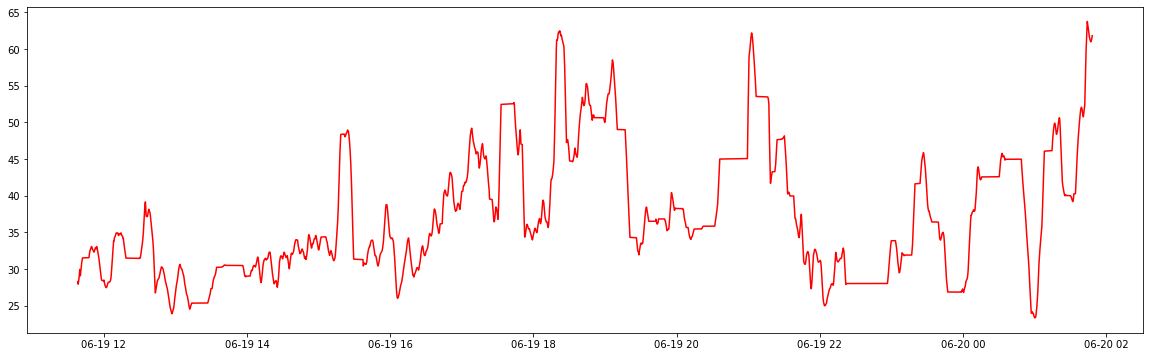

In [36]:
region_of_interest_start = events_df['Starting Timestamp']
region_of_interest_end = events_df['Ending Timestamp']


fig, ax = plt.subplots(figsize=(20,6))
ax.plot(hrv_features['datetime'],hrv_features['MAG_K500'],color='red')
ax.axvspan(region_of_interest_start, region_of_interest_end,label="Region of Interests",color="blue", alpha=0.3)
# ax.axvspan(Speech_start, Speech_end,label="Speech Emotion",color="green", alpha=0.3)
# ax.axvspan(Food_start, Food_end,label="Food Selection",color="orange", alpha=0.3)
ax.legend()

In [22]:
# date_column = hrv_features.iloc[:, 0]
# feature_column = hrv_features['MAG_K500']

def find_above_threshold_indices(column):
    indices = []
    for i in range(len(column)):
        if column[i] >= mean_rmssd:
            indices.append(i)
    return indices

hrv_desired_indices = find_above_threshold_indices(hrv_features['MAG_K500'])
hrv_desired_indices

[2381,
 2382,
 2383,
 2384,
 2385,
 2386,
 2387,
 2388,
 2389,
 2390,
 2391,
 2392,
 2393,
 2394,
 2395,
 2396,
 2397,
 2398,
 2399,
 2400,
 2401,
 2402,
 2403,
 2404,
 2405,
 2406,
 2407,
 2408,
 2409,
 2410,
 2411,
 2412,
 2413,
 2414,
 2415,
 2416,
 2417,
 2418,
 2419,
 2420,
 2421,
 2422,
 2423,
 2424,
 2425,
 2426,
 2427,
 2428,
 2429,
 2430,
 2431,
 2432,
 2433,
 2434,
 2435,
 2436,
 2437,
 2438,
 2439,
 2440,
 2441,
 2442,
 2443,
 2444,
 2445,
 2446,
 2447,
 2448,
 2449,
 2450,
 2451,
 2452,
 2453,
 2454,
 2455,
 2456,
 2457,
 2458,
 2459,
 2460,
 2461,
 2462,
 2463,
 2464,
 2465,
 2466,
 2467,
 2468,
 2469,
 2470,
 2471,
 2472,
 2473,
 2474,
 2475,
 2542,
 2543,
 2544,
 2545,
 2546,
 2547,
 2548,
 2549,
 2550,
 2551,
 2552,
 2553,
 2554,
 2555,
 2556,
 2557,
 2558,
 2559,
 2560,
 2561,
 2562,
 2563,
 2564,
 2565,
 2566,
 2567,
 2568,
 2569,
 2570,
 2571,
 2572,
 2573,
 2574,
 2575,
 2576,
 2577,
 2578,
 2579,
 2580,
 2581,
 2582,
 2583,
 2584,
 2585,
 2586,
 2587,
 2588,
 2589,

In [23]:
a = hrv_features['MAG_K100']

[x[1] for x in enumerate(a) if x[0] in hrv_desired_indices]


[50.52724359226966,
 50.827919733075376,
 51.131782537184826,
 51.43883200459798,
 51.74906813531482,
 52.062490929335375,
 52.37910038665963,
 52.69776671703006,
 53.016433047400504,
 53.335099377770945,
 53.65376570814138,
 53.97877785796572,
 54.30242668944169,
 54.63189936240298,
 54.92170683140661,
 55.190709943381435,
 55.45652639205257,
 55.719156177419976,
 55.978599299483704,
 56.234855758243704,
 56.48792555370002,
 56.73780868585261,
 56.984505154701516,
 57.22801496024671,
 57.4683381024882,
 57.70547458142599,
 57.939424397060066,
 58.17018754939045,
 58.397764038417115,
 58.62215386414009,
 58.84335702655935,
 59.06137352567491,
 59.268361978192985,
 59.46599943005485,
 59.645684840611445,
 59.8154070977745,
 59.97495923222514,
 60.12017613034308,
 60.26220636515731,
 60.40104993666783,
 60.53670684487465,
 60.66917708977777,
 60.80328874339415,
 60.937012744283926,
 61.067550081869996,
 61.189928751000295,
 61.306465679384885,
 61.41346113094515,
 61.50679450230066,
 61.

In [24]:
subdf = hrv_features.loc[hrv_desired_indices, :]


subdf = subdf.loc[:, ['datetime', 'MAG_K500']]
subdf

datetime   MAG_K500
2381  2021-06-19 12:33:58+00:00  37.249042
2382  2021-06-19 12:33:59+00:00  37.296303
2383  2021-06-19 12:34:00+00:00  37.344150
2384  2021-06-19 12:34:01+00:00  37.392303
2385  2021-06-19 12:34:02+00:00  37.441476
...                         ...        ...
33981 2021-06-20 01:48:08+00:00  61.746558
33982 2021-06-20 01:48:09+00:00  61.768059
33983 2021-06-20 01:48:10+00:00  61.789869
33984 2021-06-20 01:48:11+00:00  61.811989
33985 2021-06-20 01:48:12+00:00  61.834419

[12784 rows x 2 columns]

In [25]:
fig = px.line(subdf, y='MAG_K500', x = 'datetime')
fig.show()

In [26]:
subdf['datetime'] = subdf['datetime'].astype(str)

In [27]:
subdf2 = subdf.reindex(list(range(0,subdf.index.max()+1)))
subdf2

datetime   MAG_K500
0                            NaN        NaN
1                            NaN        NaN
2                            NaN        NaN
3                            NaN        NaN
4                            NaN        NaN
...                          ...        ...
33981  2021-06-20 01:48:08+00:00  61.746558
33982  2021-06-20 01:48:09+00:00  61.768059
33983  2021-06-20 01:48:10+00:00  61.789869
33984  2021-06-20 01:48:11+00:00  61.811989
33985  2021-06-20 01:48:12+00:00  61.834419

[33986 rows x 2 columns]

In [28]:
time_reindex_df = subdf.reindex(list(range(0,subdf.index.max()+1)), fill_value = 0)
time_reindex_df

datetime   MAG_K500
0                              0   0.000000
1                              0   0.000000
2                              0   0.000000
3                              0   0.000000
4                              0   0.000000
...                          ...        ...
33981  2021-06-20 01:48:08+00:00  61.746558
33982  2021-06-20 01:48:09+00:00  61.768059
33983  2021-06-20 01:48:10+00:00  61.789869
33984  2021-06-20 01:48:11+00:00  61.811989
33985  2021-06-20 01:48:12+00:00  61.834419

[33986 rows x 2 columns]

In [29]:
time_stamp_df = pd.to_datetime(time_reindex_df['datetime'])
time_stamp_df

0       1970-01-01 00:00:00+00:00
1       1970-01-01 00:00:00+00:00
2       1970-01-01 00:00:00+00:00
3       1970-01-01 00:00:00+00:00
4       1970-01-01 00:00:00+00:00
                   ...           
33981   2021-06-20 01:48:08+00:00
33982   2021-06-20 01:48:09+00:00
33983   2021-06-20 01:48:10+00:00
33984   2021-06-20 01:48:11+00:00
33985   2021-06-20 01:48:12+00:00
Name: datetime, Length: 33986, dtype: datetime64[ns, UTC]

In [30]:
subdf2.to_csv('subdf2.csv')